# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


# Brief summarize. Point 2.
Imported all the necessary libraries and readed the file csv, parsing to datetime the first column.

## Preparation

In [2]:
taxi = taxi.resample('1H').sum()# < write code here >
taxi.sort_index(inplace=True)
display(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [3]:
taxi['rolling_mean'] = taxi.rolling(24).mean()
taxi['std'] = taxi['num_orders'].rolling(24).std()
display(taxi)

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,167.541667,63.268908
2018-08-31 20:00:00,154,168.041667,63.105487
2018-08-31 21:00:00,159,166.416667,62.801908


In [4]:
taxi.dropna(inplace=True)
print(taxi.isna().sum())

num_orders      0
rolling_mean    0
std             0
dtype: int64


# Brief summarize. Point 3.
Resampled the date to 1 hour. Added rolling mean and standard deviation column to my data. 
To fill missing values I utilized the backfill method.

## Analysis

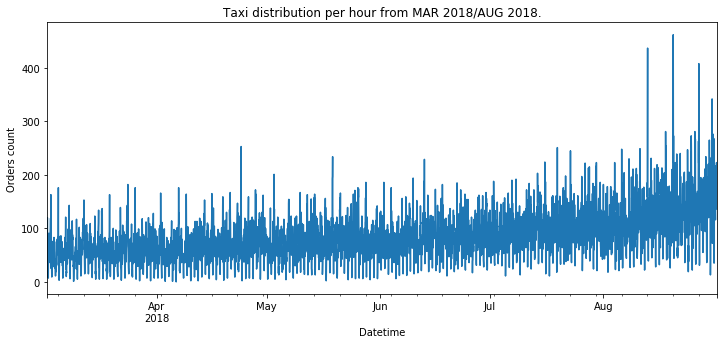

In [5]:
plt.figure(figsize=(12,5))
taxi['num_orders'].plot()
plt.title('Taxi distribution per hour from MAR 2018/AUG 2018.')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show()

<Figure size 864x360 with 0 Axes>

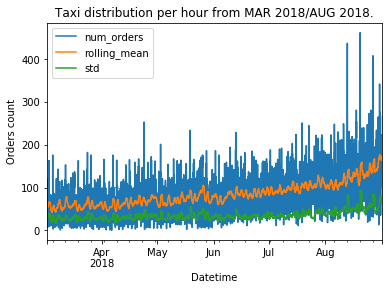

In [6]:
plt.figure(figsize=(12,5))
taxi.plot()
plt.title('Taxi distribution per hour from MAR 2018/AUG 2018.')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show()

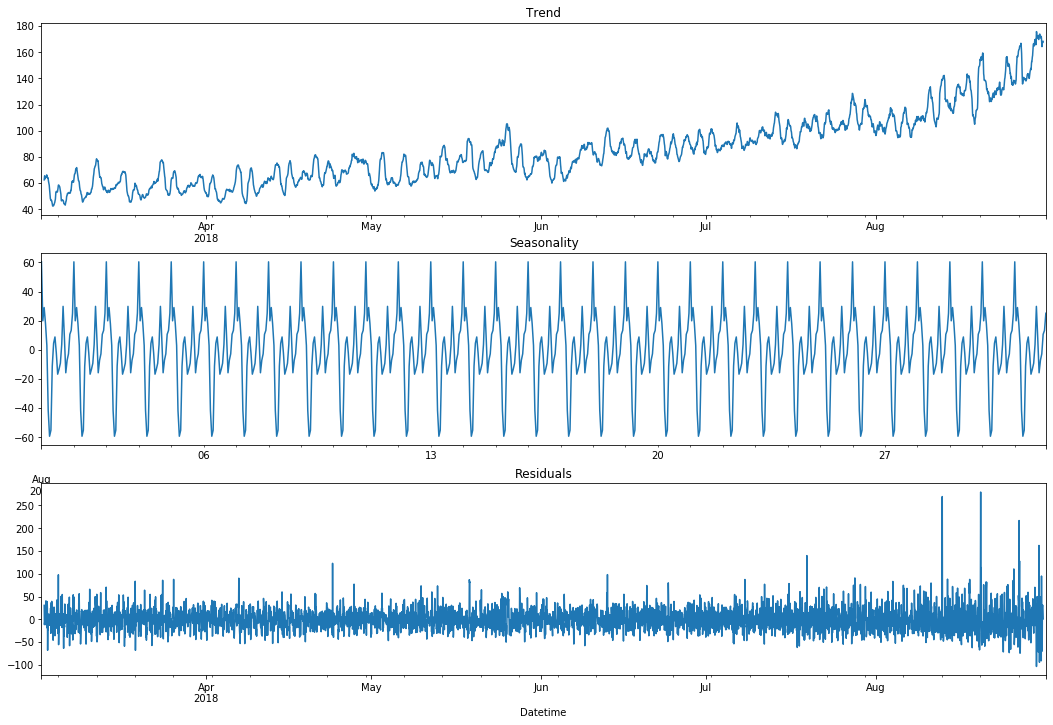

In [11]:
#Plotting Trend, Seasonality and Residuals.
decomposed = seasonal_decompose(taxi['num_orders'])
decomposed.seasonal = decomposed.seasonal['2018-08-01':'2018-08-31']
plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Datetime')
plt.show()

In [12]:
#Creating a stationary time serie.
data = taxi - taxi.shift()
data = data.drop(['rolling_mean'], axis=1)
data = data.drop(['std'], axis=1)

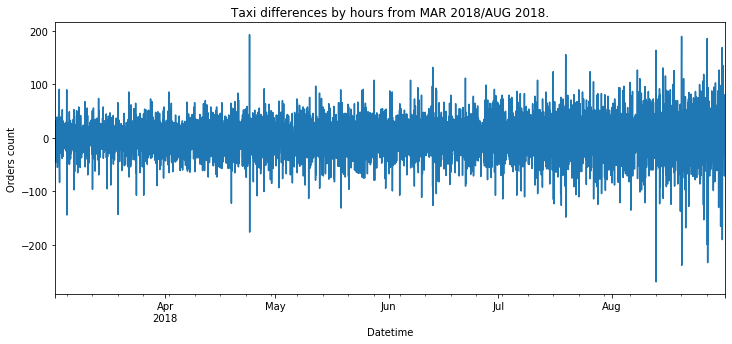

In [13]:
plt.figure(figsize=(12,5))
data['num_orders'].plot()
plt.title('Taxi differences by hours from MAR 2018/AUG 2018.')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show()

In [14]:
#Looking for outliers.
display(data.query('num_orders > 100'))

,num_orders
datetime,
2018-04-24 00:00:00,193.0
2018-05-28 02:00:00,108.0
2018-06-07 00:00:00,108.0
2018-06-13 02:00:00,132.0
2018-06-22 00:00:00,112.0
2018-07-11 17:00:00,108.0
2018-07-16 00:00:00,124.0
2018-07-19 10:00:00,156.0
2018-07-26 02:00:00,124.0


In [15]:
display(data.query('num_orders < -100'))

,num_orders
datetime,
2018-03-05 02:00:00,-144.0
2018-03-19 02:00:00,-143.0
2018-03-24 02:00:00,-107.0
2018-03-26 02:00:00,-107.0
2018-04-19 01:00:00,-122.0
2018-04-24 01:00:00,-176.0
2018-04-26 01:00:00,-108.0
2018-05-10 04:00:00,-113.0
2018-05-19 01:00:00,-131.0


In [16]:
#Replacing outlier with median scores.
data['num_orders'] = np.where((data['num_orders'] > 100), data['num_orders'].median(), data['num_orders'])
data['num_orders'] = np.where((data['num_orders'] < -100), data['num_orders'].median(), data['num_orders'])

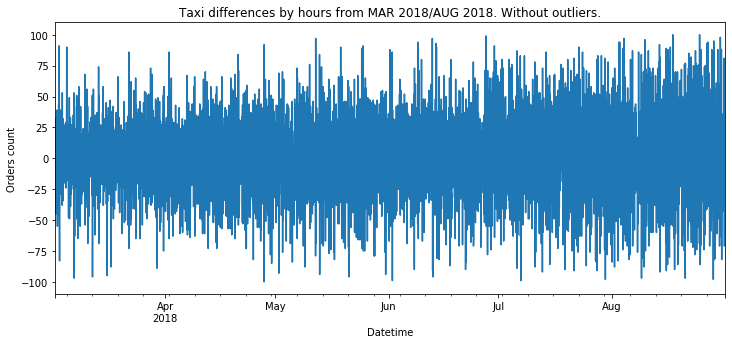

In [17]:
#Plotting the results. Final data without outliers.
plt.figure(figsize=(12,5))
data['num_orders'].plot()
plt.title('Taxi differences by hours from MAR 2018/AUG 2018. Without outliers.')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show()

# Brief summarize. Point 4.
- Plotted the distribution of orders per hour on the entire dataset. 
- Plotted the distribution with rolling mean and standard deviation. 
- Analyzed trend, seasonality, residuals for num_orders column. 
- Dropped all the columns except for num_orders to return to initial data without calculations.
- Created a stationary time serie to render data in linear form. 
- Removed outliers from my data. 

## Training

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print()
print('Median daily power consumption:', test.median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('MAE:', mean_absolute_error(test.values, pred_median))
print()
print('Median daily power consumption:', test.median())
pred_previous = np.ones(test.shape[0]) * test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
print('MAE:', mean_absolute_error(test['num_orders'].values, pred_previous))

2018-03-01 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00

Median daily power consumption: num_orders    1.0
dtype: float64
MAE: 35.30909090909091

Median daily power consumption: num_orders    1.0
dtype: float64
MAE: 55.00681818181818


In [19]:
#Creating features.
def make_features(data, max_lag, rolling_mean_size, std_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(std_mean_size).mean()
    
make_features(data, 5, 10,10)
data.dropna(inplace=True)
display(data)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,std
datetime,,,,,,,,,,,,
2018-03-02 10:00:00,9.0,2018,3,2,4,-1.0,39.0,-4.0,0.0,-9.0,-1.3,-1.3
2018-03-02 11:00:00,37.0,2018,3,2,4,9.0,-1.0,39.0,-4.0,0.0,-3.6,-3.6
2018-03-02 12:00:00,-55.0,2018,3,2,4,37.0,9.0,-1.0,39.0,-4.0,-2.9,-2.9
2018-03-02 13:00:00,9.0,2018,3,2,4,-55.0,37.0,9.0,-1.0,39.0,-3.9,-3.9
2018-03-02 14:00:00,-1.0,2018,3,2,4,9.0,-55.0,37.0,9.0,-1.0,-1.9,-1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,2018,8,31,4,-10.0,20.0,81.0,-17.0,-33.0,2.5,2.5
2018-08-31 20:00:00,18.0,2018,8,31,4,-71.0,-10.0,20.0,81.0,-17.0,-6.7,-6.7
2018-08-31 21:00:00,5.0,2018,8,31,4,18.0,-71.0,-10.0,20.0,81.0,-3.7,-3.7


In [20]:
#Creating a dummy model with LinearRegression
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [21]:
display(train)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,std
datetime,,,,,,,,,,,,
2018-03-02 10:00:00,9.0,2018,3,2,4,-1.0,39.0,-4.0,0.0,-9.0,-1.3,-1.3
2018-03-02 11:00:00,37.0,2018,3,2,4,9.0,-1.0,39.0,-4.0,0.0,-3.6,-3.6
2018-03-02 12:00:00,-55.0,2018,3,2,4,37.0,9.0,-1.0,39.0,-4.0,-2.9,-2.9
2018-03-02 13:00:00,9.0,2018,3,2,4,-55.0,37.0,9.0,-1.0,39.0,-3.9,-3.9
2018-03-02 14:00:00,-1.0,2018,3,2,4,9.0,-55.0,37.0,9.0,-1.0,-1.9,-1.9
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 12:00:00,-52.0,2018,8,13,0,-12.0,19.0,46.0,52.0,-27.0,-2.2,-2.2
2018-08-13 13:00:00,27.0,2018,8,13,0,-52.0,-12.0,19.0,46.0,52.0,-7.5,-7.5
2018-08-13 14:00:00,-17.0,2018,8,13,0,27.0,-52.0,-12.0,19.0,46.0,-4.9,-4.9


In [22]:
display(test)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,std
datetime,,,,,,,,,,,,
2018-08-13 17:00:00,8.0,2018,8,13,0,-31.0,73.0,-17.0,27.0,-52.0,7.8,7.8
2018-08-13 18:00:00,-48.0,2018,8,13,0,8.0,-31.0,73.0,-17.0,27.0,11.3,11.3
2018-08-13 19:00:00,-13.0,2018,8,13,0,-48.0,8.0,-31.0,73.0,-17.0,1.3,1.3
2018-08-13 20:00:00,-9.0,2018,8,13,0,-13.0,-48.0,8.0,-31.0,73.0,-4.6,-4.6
2018-08-13 21:00:00,78.0,2018,8,13,0,-9.0,-13.0,-48.0,8.0,-31.0,-7.4,-7.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,2018,8,31,4,-10.0,20.0,81.0,-17.0,-33.0,2.5,2.5
2018-08-31 20:00:00,18.0,2018,8,31,4,-71.0,-10.0,20.0,81.0,-17.0,-6.7,-6.7
2018-08-31 21:00:00,5.0,2018,8,31,4,18.0,-71.0,-10.0,20.0,81.0,-3.7,-3.7


In [23]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
predictions_train = model.predict(features_train)
print("MAE for the training set:", mean_absolute_error(predictions_train, target_train))
print("MAE for the test set: ", mean_absolute_error(predictions_test, target_test))
print('Model RMSE for the training set:', mean_squared_error(predictions_test, target_test)**0.5)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

MAE for the training set: 24.173474569055283
MAE for the test set:  35.41226128147456
Model RMSE for the training set: 44.53687388892847
Model RMSE for the test set: 44.53687388892847


In [24]:
### Creating pipelines.
pipe_dtr = Pipeline([('scaler0', StandardScaler()),
                    ('DecisionTreeRegressor', DecisionTreeRegressor())])

pipe_rfr = Pipeline([('scaler1', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100))])

pipe_linear = Pipeline([('scaler2', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])

pipe_cat_boost_r = Pipeline([('scaler3', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(verbose=500))])

pipe_lgbm_r =  Pipeline([('scaler4', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor())])

pipe_xgb_r = Pipeline([('scaler5', StandardScaler()),
                       ('XGBRegressor', XGBRegressor())])

In [25]:
#Creating list of pipelines.
pipelines = [pipe_dtr, pipe_rfr, pipe_linear, pipe_cat_boost_r, pipe_lgbm_r, pipe_xgb_r]
#Creating a dictionary of pipelines.
pipe_dict = {pipe_dtr: 'DecisionTreeRegressor', pipe_rfr:'RandomForestRegressor', pipe_linear:'LinearRegression',\
             pipe_cat_boost_r: 'CatBoostRegressor', pipe_lgbm_r: 'LGBMRegressor', pipe_xgb_r:'XGBRegressor'}

In [26]:
#Defining a function to calculate RMSE.
def rmse(target,predictions): 
    score = mean_squared_error(target, predictions)
    score = score **0.5
    return score

In [27]:
#Looping trough pipelines to obtain cross validation scores.
rmse = make_scorer(rmse, greater_is_better=False)
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring = rmse, cv=5))

DecisionTreeRegressor
[-38.97958583 -39.62103434 -41.97053707 -44.13114972 -49.13692926]
RandomForestRegressor
[-25.94152271 -26.93912217 -29.34069737 -31.03343304 -36.51038323]
LinearRegression
[-26.2654808  -27.61762746 -30.61843304 -31.55622917 -37.43094503]
CatBoostRegressor
0:	learn: 34.3695186	total: 49.4ms	remaining: 49.3s
500:	learn: 25.6602266	total: 8.03s	remaining: 8s
999:	learn: 22.0568415	total: 16s	remaining: 0us
0:	learn: 33.8779413	total: 2.14ms	remaining: 2.13s
500:	learn: 25.4719429	total: 8.3s	remaining: 8.27s
999:	learn: 21.9553582	total: 16.2s	remaining: 0us
0:	learn: 33.1971482	total: 2.09ms	remaining: 2.08s
500:	learn: 25.1209506	total: 8.26s	remaining: 8.23s
999:	learn: 21.7777436	total: 16s	remaining: 0us
0:	learn: 32.9320331	total: 2.12ms	remaining: 2.12s
500:	learn: 24.5609652	total: 7.98s	remaining: 7.95s
999:	learn: 20.8998330	total: 16.2s	remaining: 0us
0:	learn: 31.4947711	total: 2.23ms	remaining: 2.23s
500:	learn: 23.4432848	total: 9.21s	remaining: 9.17s

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-25.99597946 -27.12286351 -29.17918781 -30.8672145  -36.71103585]


In [38]:
#Creating a tree based model with best hyperparameters.
parameters = {'n_estimators': (110,150,200,230,250,80,300),
              'max_depth': (7,8,10,12,16,19,25),
              } 

#Creating a grid model.
RF_grid = GridSearchCV(RandomForestRegressor(random_state=0, criterion='mse'), param_grid=parameters, \
                       cv=5, scoring=rmse, n_jobs=-1)
RF_grid_model = RF_grid.fit(features_train, target_train)
print(RF_grid_model.best_estimator_)
print(RF_grid_model.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
-29.73325195049335


In [39]:
#Creating a gradient boosting descent model with best hyperparameters.
warnings.simplefilter(action='ignore', category=FutureWarning)

parameters = {'learning_rate': (0.15,0.1,0.2,0.3,0.25,0.05),
              'n_estimators': (200,350,450,150,100,120),
              'base_score': (0.25, 0.5, 0.75)
              } 

#Creating a grid model.
XGB_grid = GridSearchCV(XGBRegressor(), param_grid=parameters, cv=5, scoring=rmse, n_jobs=-1) 
XGB_grid_model = XGB_grid.fit(features_train, target_train)
print(XGB_grid_model.best_estimator_)
print(XGB_grid_model.best_score_)

[12:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:14:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[12:16:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [31]:
#Creating a gradient boosting descent model tuning best hyperparameters.
parameters = {'learning_rate': (0.05,0.04,0.03,0.02,0.06,0.07,0.08),
              'n_estimators': (200,350,450,150,100,120),
              } 

#Creating a grid model.
LGBM_grid = GridSearchCV(LGBMRegressor(), param_grid=parameters, cv=5, scoring=rmse, n_jobs=1) 
LGBM_grid_model = LGBM_grid.fit(features_train, target_train)
print(LGBM_grid_model.best_estimator_)
print(LGBM_grid_model.best_score_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
-29.786096937835783


# Brief summarize. Point 5.
Divided train and test assigning 0.1 to the test size, shuffle = False to don't shuffle my data.
- Train index from 2018-03-01 00:00:00 to 2018-08-13 13:00:00
- Test index from 2018-08-13 14:00:00 to 2018-08-31 23:00:00. 

After calculating MAE using median and previous prediction method I obtained:
- Median method returned MAE: 35.30909090909091
- Previous value method returned MAE: 55.00681818181818

Created the features of the dataset extracting day, month and year from the indexes, assigning 5 level of lag. 10 was the choosen value to calculate again rolling_mean and standard deviation from the final shifted values. Recreated the train and test set with the same parameters after adding the new features column. 

With a base LinearRegression calculated the MAE and RMSE metric obtaining:
- MAE for the training set: 24.173474569055283
- MAE for the test set:  35.41226128147456
- Model RMSE for the training set: 44.53687388892847
- Model RMSE for the test set: 44.53687388892847

Created Pipelines for the CV on the main models. After CV on training set. I got the following results:

- DecisionTreeRegressor [-38.97958583 -39.62103434 -41.97053707 -44.13114972 -49.13692926]
- RandomForestRegressor [-25.94152271 -26.93912217 -29.34069737 -31.03343304 -36.51038323]
- LinearRegression [-26.2654808  -27.61762746 -30.61843304 -31.55622917 -37.43094503]
- CatBoostRegressor [-25.80803627 -26.44933561 -28.54436251 -30.42140031 -35.81517806]
- LGBMRegressor [-26.21709043 -26.86630834 -29.41202436 -31.30527236 -36.44937238]
- XGBRegressor [-25.99597946 -27.12286351 -29.17918781 -30.8672145  -36.71103585]

Proceeded with the tuning of hyperparameters for RandomForestRegressor(model) and XGBRegressor (gradient descent algorithim).

## Testing

In [32]:
model = Pipeline([('scaler0', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

Model RMSE for the test set: 44.53687388892846


In [40]:
model = Pipeline([('scaler1', StandardScaler()),
                ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False))])
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

Model RMSE for the test set: 43.46853315440498


In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)

model = Pipeline([('scaler2', StandardScaler()),
        ('XGBRegressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1))])
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

[12:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model RMSE for the test set: 44.20948080238403


In [36]:
model = Pipeline([('scaler3', StandardScaler()),
        ('LGBMRegressor', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

Model RMSE for the test set: 43.51361398763156


# Brief summarize. Point 6.
Created pipelines for the defined models, creted pipelines with scaler and instances of models and calculated RMSE on the testing set. The choosen models were: 

- LinearRegression RMSE: 44.53687388892846
- RandomForestRegressor RMSE: 43.46853315440498
- XGBRegressor RMSE: 44.20948080238403
- LGBMRegressor RMSE: 43.51361398763156


XGBRegressor looks to be the best algorithim to deal with this task. Obtained 44.80 compared to the max value to succeed in the project wich was 48.

# Overall Conclusion
Sweet Lift Taxi company needed to build model to predict the amount of taxi orders for the next hour. Requirement for the model was that the RMSE metric on the test set should not be more than 48. After preparing and analyzing my data I passed to the model training and testing phases. I tried couple of different models. They performed the task pretty in similar ways, obtaining better results then the stated one. The better one was The RandomForestRegressor built with 29.733 as training set RMSE and 43.468 as testing set RMSE. 

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48